In [1]:
# Run quadratic parameteisation
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import multimelt.melt_functions as meltf
from multimelt.constants import *

2025-11-13 16:16:09.342697: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 16:16:09.349067: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 16:16:09.600651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 16:16:11.272601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [3]:
from parameter_selection_toolbox import *

# Load datasets

In [4]:
# Load climatology
climatology = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/climatology/zhou_annual_30_sep/OI_Climatology_ismip8km_60m_tf_extrap.nc")
salinity = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/climatology/zhou_annual_30_sep/OI_Climatology_ismip8km_60m_so_extrap.nc")

# Load BedMap3
bed = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/topography/bedmap3_ismip_8km.nc")

# get thermal forcing at the ice shelf draft
tf_draft = climatology.tf.sel(z=bed['draft'], method='nearest')
tf_draft = tf_draft.where(tf_draft>0, 0) # remove negative values
tf_draft = tf_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
so_draft = so_draft.where(so_draft>0, 0) # remove negative values
S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

# Create parameters

In [18]:
# Create parameter array
K = xr.DataArray(data=np.arange(1.0e-5,15.05e-5,0.5e-5), dims=['K_dim']).assign_coords({'K_dim': np.arange(1.0e-5,15.05e-5,0.5e-5)}) 
K

<xarray.DataArray (K_dim: 29)> Size: 232B
array([1.00e-05, 1.50e-05, 2.00e-05, 2.50e-05, 3.00e-05, 3.50e-05,
       4.00e-05, 4.50e-05, 5.00e-05, 5.50e-05, 6.00e-05, 6.50e-05,
       7.00e-05, 7.50e-05, 8.00e-05, 8.50e-05, 9.00e-05, 9.50e-05,
       1.00e-04, 1.05e-04, 1.10e-04, 1.15e-04, 1.20e-04, 1.25e-04,
       1.30e-04, 1.35e-04, 1.40e-04, 1.45e-04, 1.50e-04])
Coordinates:
  * K_dim    (K_dim) float64 232B 1e-05 1.5e-05 2e-05 ... 0.000145 0.00015

In [19]:
# Create deltaT corrections array
deltaT = np.linspace(-2,3,101)#, 3) # go up to 3 for melt sensitivity calculation
deltaT

array([-2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 ,
       -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15,
       -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 ,
       -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25,
       -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
        0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
        0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,
        1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,
        1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,
        2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,
        2.5 ,  2.55,  2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,
        2.95,  3.  ])

# Create dataset that we will run the optimisation over depending on K and deltaT, write also ensemble table

In [120]:
with open('ensemble_quadratic.txt', 'w') as fh:
    fh.write("ehash K dummy\n")

for i,k in enumerate(K):
    members = []
    
    for dT in deltaT:
        thermal_forcing = (tf_draft+dT).where((tf_draft+dT)>0, 0).where(bed.floating_frac>0.5, np.nan)        
        ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
        ds = ds.assign_coords(deltaT=dT)
        members.append(ds)
    ensemble = xr.concat(members, dim='deltaT', coords='minimal')
    ensemble.to_netcdf("/mnt/FastStore1/quadratic_out/pd_zhou_"+str(i)+".nc") 
    with open('ensemble_quadratic.txt', 'a') as fh:
        fh.write(str(i)+" "+str(k.values)+" 1 \n")
    

# Now optimise deltaT

In [20]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/"
ensemble_path="/mnt/FastStore1/quadratic_out/"

# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]


# parameterisation ensemble table 
p1_name = 'K'
p2_name = 'dummy'

quadratic_present_day_ensemble = "ensemble_quadratic"
ensemble_table = pd.read_csv('./'+quadratic_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)

ensemble_table

,K,dummy
ehash,,
0,0.000010,1
1,0.000015,1
2,0.000020,1
3,0.000025,1
4,0.000030,1
5,0.000035,1
6,0.000040,1
7,0.000045,1
8,0.000050,1


In [21]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset("basinNumbers_8km.nc")
basins = basins.rename({'basinNumber':'basins'})
# shift by 1 to start at 1
basins['basins'] = basins['basins']+1
number_of_basins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset('melt_paolo_err_adusumilli_ismip8km.nc') # Field
MeltDataImbie = pd.read_csv('Paolo23/Melt_Paolo_Err_Adusumilli_imbie2.csv', index_col=0) # Aggregated per imbier basin
MeltDataImbie.index = MeltDataImbie.index+1

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset("BFRN_ismip8km.nc")
nBins = 10

In [123]:
model_runs = [] 
p1s = []
p2s = []

for i,ehash in enumerate(ensemble_table.index):
    
    p1 = ensemble_table.loc[ehash, p1_name]
    p2 = ensemble_table.loc[ehash, p2_name]
    p1s.append(p1)
    p2s.append(p2) 
    print(i, 'p1=', p1, ' p2=', p2)

    output_path = os.path.join(ensemble_path, "pd_zhou_"+str(ehash) )
    #print(output_path)

    try:
        print('Loading dataset')
        result_ds = xr.load_dataset(output_path+"_optimised.nc")
    except:
        ds = xr.open_dataset(os.path.join(output_path+'.nc')) #,decode_timedelta=True)
        ds = ds.rename({'__xarray_dataarray_variable__': 'melt_rate'})
        outname = output_path+"_optimised.nc"
        
        result_ds = select_optimal_deltaT(ds, basins['basins'], None ,MeltDataImbie, 'quadratic', outname, reso, ice_density)
    
    result_ds = result_ds.assign_coords(ehash=ehash)
    model_runs.append(result_ds)

0 p1= 1e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
1 p1= 1.5000000000000002e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
2 p1= 2.0000000000000005e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
3 p1= 2.5000000000000005e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
4 p1= 3.0000000000000004e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
5 p1= 3.5000000000000004e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
6 p1= 4.000000000000001e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
7 p1= 4.500000000000001e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
8 p1= 5.000000000000001e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
9 p1= 5.500000000000001e-05  p2= 1
Loading dataset
Identifying optimal delta T for each basin...
10 p1= 6.000000000000001e-05  p2= 1
Loadi

In [124]:
print('Combining datasets')
pd_ensemble_sel = xr.concat(model_runs, dim='ehash', coords='minimal')

# change ehash to C and gammaT dimensions
pd_ensemble_sel = pd_ensemble_sel.assign_coords({ 
    'p1': ('ehash', p1s),
    'p2': ('ehash', p2s)
}).set_index(ehash=['p1', 'p2']).unstack('ehash')

# Save pd_ensemble_sel
pd_ensemble_sel.encoding = {}
pd_ensemble_sel.to_netcdf('Quadratic_ensemble_pd_optimaldeltaT.nc')

Combining datasets


# Create figures

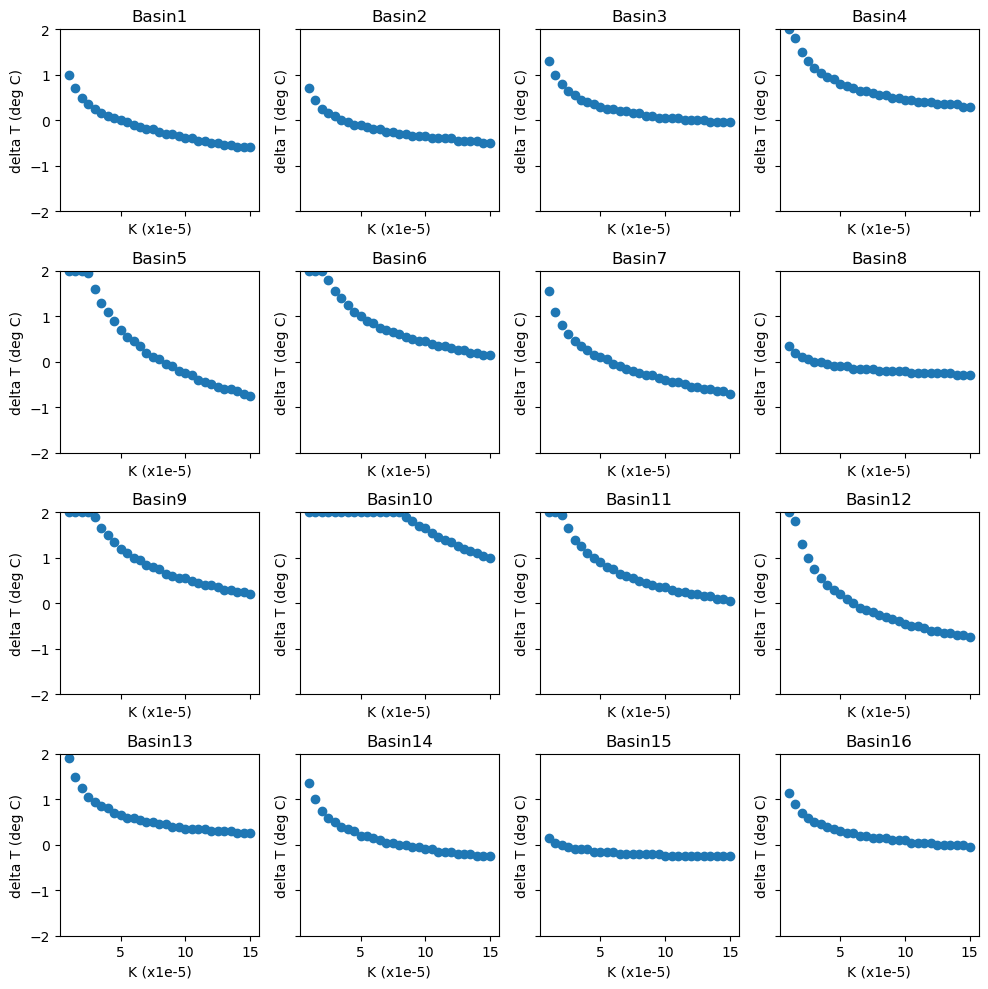

In [125]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['optimal_deltaT_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('delta T (deg C)')
    
    ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_deltaTPerBasin.png'))


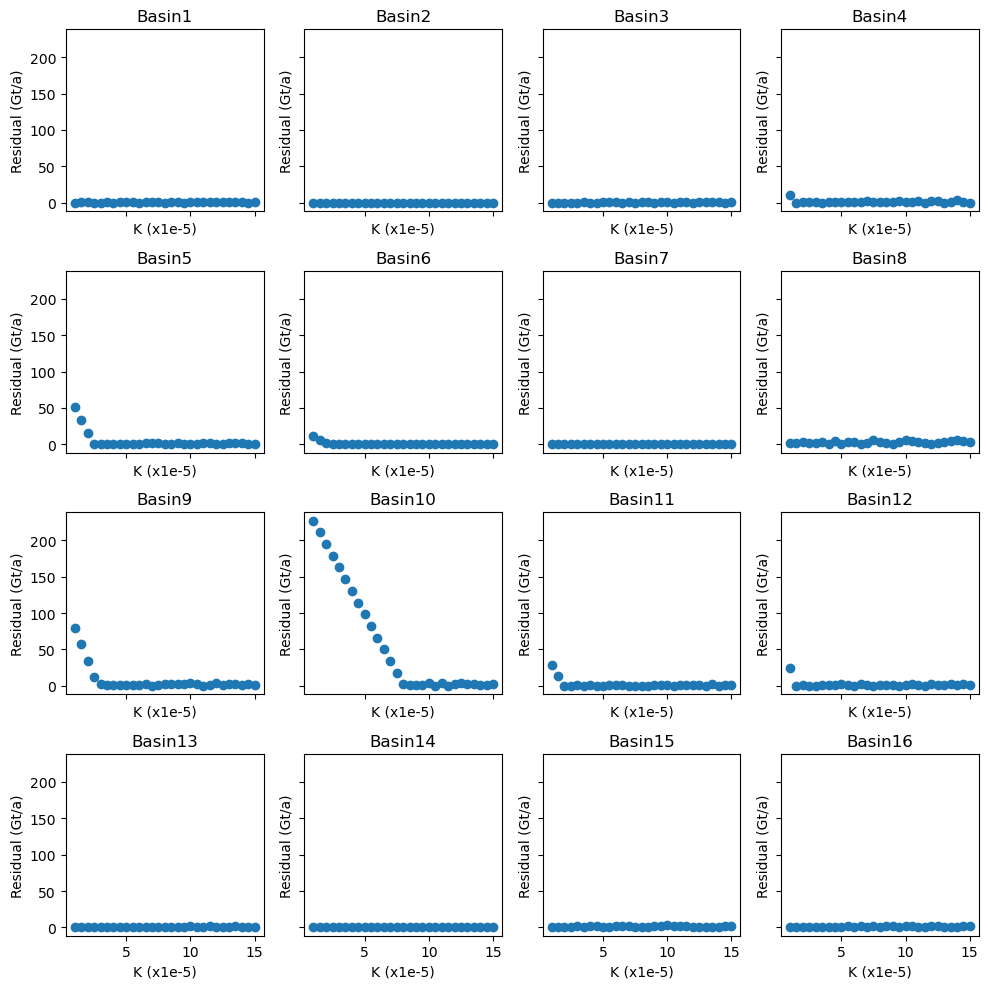

In [126]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['residual_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('Residual (Gt/a)')
    #ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_residualPerBasin.png'))


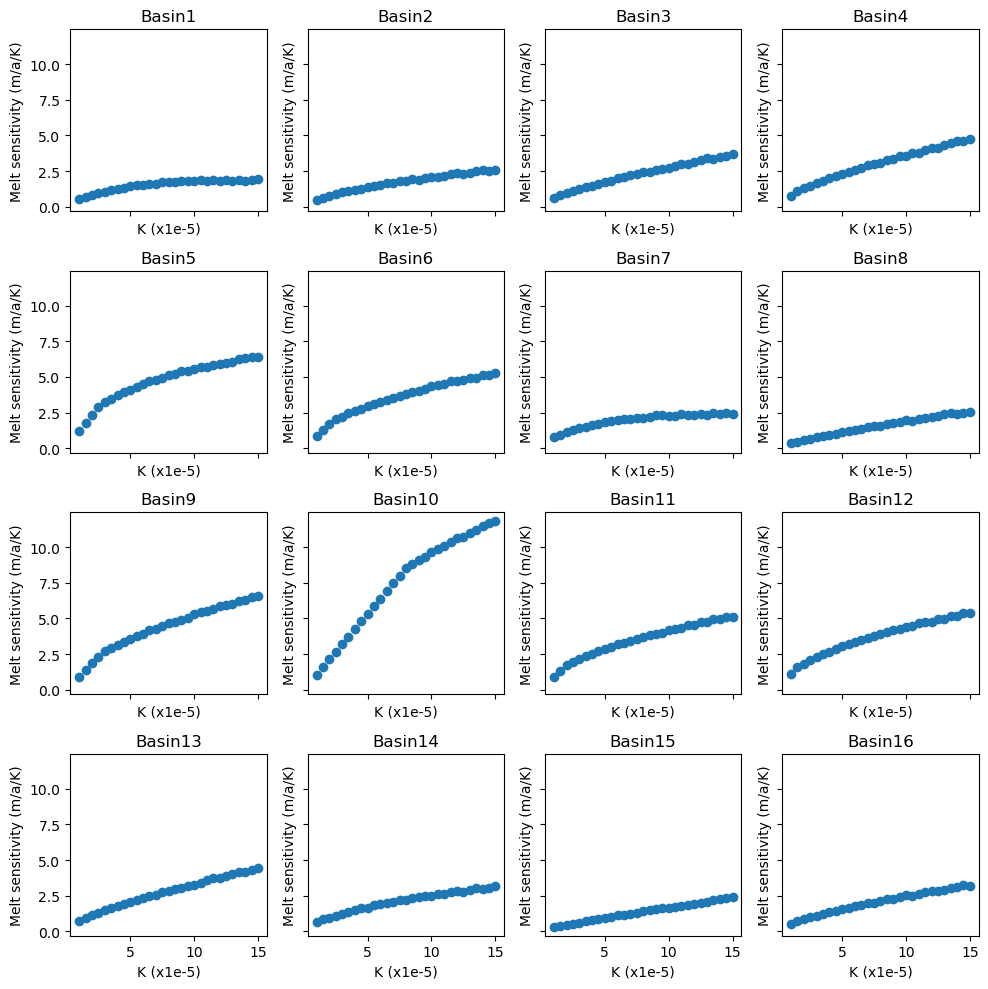

In [127]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['sensitivity_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('Melt sensitivity (m/a/K)')
    #ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_SensitivityPerBasin.png'))


# Apply optimal deltaT to ocean modelling datasets

In [22]:

opt_ensemble = xr.load_dataset('Quadratic_ensemble_pd_optimaldeltaT.nc')
#basins = basins['basins']


In [129]:
# create ensemble for Mathiot data 
ensemble_names = ["Mathiot23_cold", "Mathiot23_warm"]
datasets = ["Mathiot23_cold_clean_", "Mathiot23_warm_clean_"]

for j,dataset in enumerate(datasets):
    ocean_modelling_data = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/meltmip/Ocean_Modelling_Data/"+dataset+"TF.nc")

    # get thermal forcing at the ice shelf draft
    tf_draft_om = ocean_modelling_data.thermal_forcing.sel(z=bed['draft'], method='nearest')
    tf_draft_om = tf_draft_om.where(tf_draft_om>0, 0) # remove negative values
    tf_draft_om = tf_draft_om.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

    ocean_modelling_data = xr.load_dataset("/media/NAS2/ISMIP7/share_with_modellers/meltmip/Ocean_Modelling_Data/"+dataset+"S.nc")
    # get thermal forcing at the ice shelf draft
    so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
    so_draft = so_draft.where(so_draft>0, 0) # remove negative values
    S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves
    
    U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0
        
    for i,k in enumerate(K):
        members = []
        for dT in deltaT:
            thermal_forcing = (tf_draft_om+dT).where((tf_draft_om+dT)>0, 0).where(bed.floating_frac>0.5, np.nan)        
            ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
            ds = ds.assign_coords(deltaT=dT)
            members.append(ds)
        ensemble = xr.concat(members, dim='deltaT', coords='minimal')
        ensemble.to_netcdf("/mnt/FastStore1/quadratic_out/"+ensemble_names[j]+"_"+str(i)+".nc")   


In [130]:
# Now use selection Krams
#basins = basins['basins']

for ensemble in ensemble_names:
    print(ensemble)
    for i,ehash in enumerate(ensemble_table.index):
        p1 = ensemble_table.loc[ehash, p1_name]
        p2 = ensemble_table.loc[ehash, p2_name]
        print(ehash, i, 'p1=', p1, ' p2=', p2)

        output_path = os.path.join("/mnt/FastStore1/quadratic_out/", ensemble+"_"+str(ehash) )
        
        ds = xr.open_dataset(os.path.join(output_path+'.nc')) #,decode_timedelta=True)
        ds = ds.rename({'__xarray_dataarray_variable__': 'melt_rate'})
        
        outname = os.path.join("/mnt/FastStore1/quadratic_out/",ensemble+"_"+str(ehash)+"_optimised.nc")
        select_subensemble_using_optimal_deltaT(ds, basins['basins'], opt_ensemble, outname, p1, p2)
        ds.close()


Mathiot23_cold
0 0 p1= 1e-05  p2= 1
Select sub-ensemble...
1 1 p1= 1.5000000000000002e-05  p2= 1
Select sub-ensemble...
2 2 p1= 2.0000000000000005e-05  p2= 1
Select sub-ensemble...
3 3 p1= 2.5000000000000005e-05  p2= 1
Select sub-ensemble...
4 4 p1= 3.0000000000000004e-05  p2= 1
Select sub-ensemble...
5 5 p1= 3.5000000000000004e-05  p2= 1
Select sub-ensemble...
6 6 p1= 4.000000000000001e-05  p2= 1
Select sub-ensemble...
7 7 p1= 4.500000000000001e-05  p2= 1
Select sub-ensemble...
8 8 p1= 5.000000000000001e-05  p2= 1
Select sub-ensemble...
9 9 p1= 5.500000000000001e-05  p2= 1
Select sub-ensemble...
10 10 p1= 6.000000000000001e-05  p2= 1
Select sub-ensemble...
11 11 p1= 6.500000000000002e-05  p2= 1
Select sub-ensemble...
12 12 p1= 7.000000000000002e-05  p2= 1
Select sub-ensemble...
13 13 p1= 7.500000000000002e-05  p2= 1
Select sub-ensemble...
14 14 p1= 8.000000000000002e-05  p2= 1
Select sub-ensemble...
15 15 p1= 8.500000000000002e-05  p2= 1
Select sub-ensemble...
16 16 p1= 9.000000000000

In [131]:
# combine datasets
quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

# Create ensemble
pd_ensemble = load_melt_rates_into_dataset(quadratic_present_day_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save pd_ensemble
pd_ensemble.encoding = {}
pd_ensemble.to_netcdf('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc')

mathiot_cold_ensemble = load_melt_rates_into_dataset(quadratic_mathiot_cold_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_cold_ensemble.encoding = {}
mathiot_cold_ensemble.to_netcdf('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc')

mathiot_warm_ensemble = load_melt_rates_into_dataset(quadratic_mathiot_warm_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_warm_ensemble.encoding = {}
mathiot_warm_ensemble.to_netcdf('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc')


Loading pd_zhou into one dataset...
0 : loading dataset for parameter 1= 1e-05  parameter 2= 1
1 : loading dataset for parameter 1= 1.5000000000000002e-05  parameter 2= 1
2 : loading dataset for parameter 1= 2.0000000000000005e-05  parameter 2= 1
3 : loading dataset for parameter 1= 2.5000000000000005e-05  parameter 2= 1
4 : loading dataset for parameter 1= 3.0000000000000004e-05  parameter 2= 1
5 : loading dataset for parameter 1= 3.5000000000000004e-05  parameter 2= 1
6 : loading dataset for parameter 1= 4.000000000000001e-05  parameter 2= 1
7 : loading dataset for parameter 1= 4.500000000000001e-05  parameter 2= 1
8 : loading dataset for parameter 1= 5.000000000000001e-05  parameter 2= 1
9 : loading dataset for parameter 1= 5.500000000000001e-05  parameter 2= 1
10 : loading dataset for parameter 1= 6.000000000000001e-05  parameter 2= 1
11 : loading dataset for parameter 1= 6.500000000000002e-05  parameter 2= 1
12 : loading dataset for parameter 1= 7.000000000000002e-05  parameter 2=

# Run Optimisation

In [23]:
quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

In [24]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset("basinNumbers_8km.nc")
basins = basins.rename({'basinNumber':'basins'})
nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset('melt_paolo_err_adusumilli_ismip8km.nc') # Field
MeltDataImbie = pd.read_csv('Paolo23/Melt_Paolo_Err_Adusumilli_imbie2.csv', index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset("BFRN_ismip8km.nc")
nBins = 10

In [25]:
# Load ensembles
pd_ensemble = xr.load_dataset('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

In [29]:
mask = bed.floating_frac>0.5

#mask.plot()

Text(0.5, 1.0, 'Optimal K for term 1')

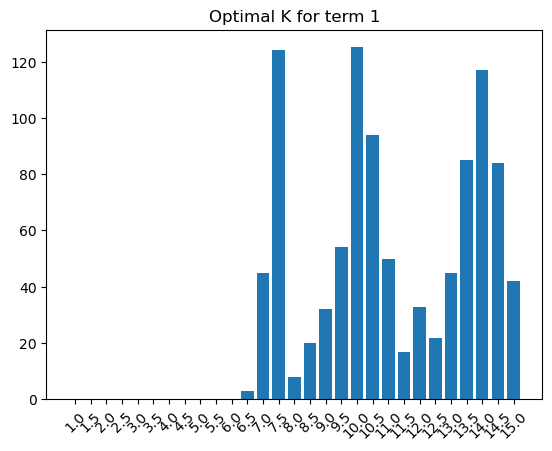

In [42]:
sample_size=1000
min_p1_t1, min_p2_t1, min_coords_t1 = calculate_objective_function('term1', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)


fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t1), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 1')


Sampling, this might take a moment...


Text(0.5, 1.0, 'Optimal K for term 2')

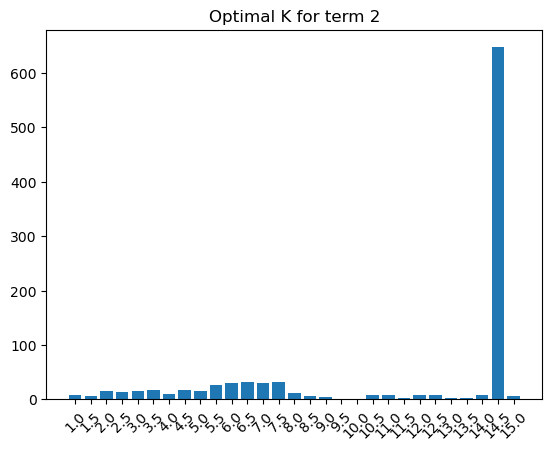

In [43]:
sample_size=1000
min_p1_t2, min_p2_t2, min_coords_t2 = calculate_objective_function('term2', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t2), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 2')


Sampling, this might take a moment...


Text(0.5, 1.0, 'Optimal K for term 3')

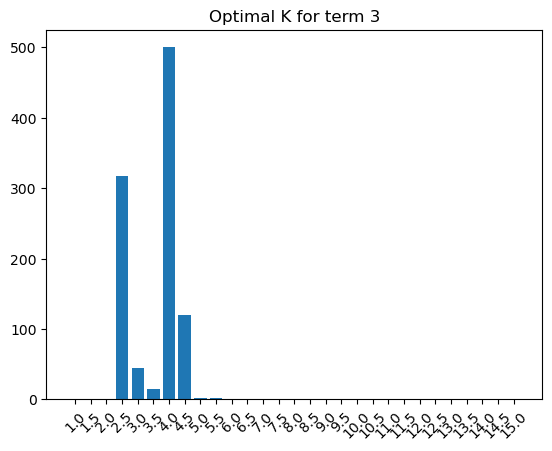

In [47]:
sample_size=1000
min_p1_t3, min_p2_t3, min_coords_t3 = calculate_objective_function('term3', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t3), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 3')


Sampling, this might take a moment...


Text(0.5, 1.0, 'Optimal K')

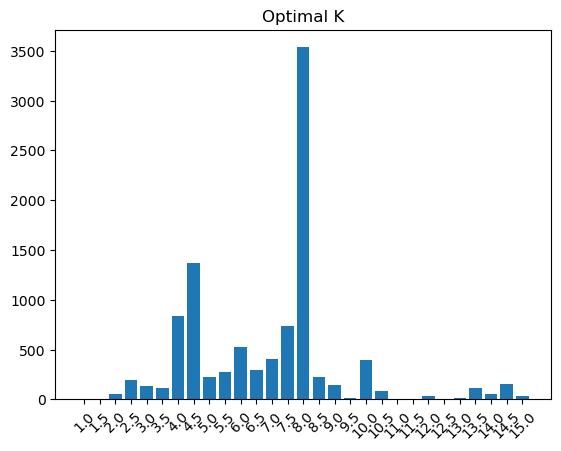

In [48]:
sample_size=10000
min_p1, min_p2, min_coords = calculate_objective_function('all', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K')


In [57]:
#print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
#print('max = ', np.max(np.array(min_p1)))


1st =  2.5000000000000005e-05
5th =  3.5000000000000004e-05
median =  7.500000000000002e-05
95th =  0.0001
99th =  0.000145


# Analyse sensitivity

In [35]:
# Based on this, reasoable PICO parameter are as median the most frequent value: gT = 2.5e-5, C= 0.75e6 
Kt= 8e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.73 m/a/K
Basin  2 : 1.8 m/a/K
Basin  3 : 2.42 m/a/K
Basin  4 : 3.08 m/a/K
Basin  5 : 5.13 m/a/K
Basin  6 : 3.82 m/a/K
Basin  7 : 2.15 m/a/K
Basin  8 : 1.58 m/a/K
Basin  9 : 4.69 m/a/K
Basin  10 : 8.52 m/a/K
Basin  11 : 3.7 m/a/K
Basin  12 : 3.94 m/a/K
Basin  13 : 2.81 m/a/K
Basin  14 : 2.22 m/a/K
Basin  15 : 1.39 m/a/K
Basin  16 : 2.12 m/a/K
Corresponding deltaT values: [-0.25 -0.3   0.15  0.55  0.05  0.6  -0.25 -0.2   0.75  2.    0.5  -0.25
  0.45  0.   -0.2   0.15]


In [36]:
Kt= 2e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 0.84 m/a/K
Basin  2 : 0.75 m/a/K
Basin  3 : 0.96 m/a/K
Basin  4 : 1.29 m/a/K
Basin  5 : 2.36 m/a/K
Basin  6 : 1.73 m/a/K
Basin  7 : 1.12 m/a/K
Basin  8 : 0.56 m/a/K
Basin  9 : 1.86 m/a/K
Basin  10 : 2.13 m/a/K
Basin  11 : 1.72 m/a/K
Basin  12 : 1.83 m/a/K
Basin  13 : 1.15 m/a/K
Basin  14 : 0.97 m/a/K
Basin  15 : 0.46 m/a/K
Basin  16 : 0.83 m/a/K
Corresponding deltaT values: [0.5  0.25 0.8  1.5  2.   2.   0.8  0.1  2.   2.   1.95 1.3  1.25 0.75
 0.   0.7 ]


In [37]:
Kt= 15e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.94 m/a/K
Basin  2 : 2.57 m/a/K
Basin  3 : 3.71 m/a/K
Basin  4 : 4.75 m/a/K
Basin  5 : 6.42 m/a/K
Basin  6 : 5.29 m/a/K
Basin  7 : 2.39 m/a/K
Basin  8 : 2.55 m/a/K
Basin  9 : 6.54 m/a/K
Basin  10 : 11.86 m/a/K
Basin  11 : 5.08 m/a/K
Basin  12 : 5.35 m/a/K
Basin  13 : 4.44 m/a/K
Basin  14 : 3.15 m/a/K
Basin  15 : 2.41 m/a/K
Basin  16 : 3.15 m/a/K
Corresponding deltaT values: [-0.6  -0.5  -0.05  0.3  -0.75  0.15 -0.7  -0.3   0.2   1.    0.05 -0.75
  0.25 -0.25 -0.25 -0.05]
